# Preparação de amostras de tweets para anotação manual 

[Voltar ao Índice](00_indice.ipynb)

Nosso objetivo aqui é selecionar amostras de tweets direcionados a candidaturas de diversos grupos sociais para que eles sejam anotados por especialistas em termos da existência de violência e da especificidade ou não do texto (se racista, machista ou LGBTfóbico).

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import scipy as sc
from importlib import reload
from pathlib import Path

import src.xavy.dataframes as xd
import src.xavy.plots as xp
import src.xavy.data_retriever as xz

import src.analysis_functions as af
import src.tweet_analysis as com

## Carregando os dados

### Perfis no twitter

Carregamos a lista de candidaturas que possuem (e sabemos) os perfis no twitter, junto com suas características. 

In [2]:
# Carrega candidaturas cadastradas no VoteLGBT:
lgbt_df = pd.read_csv(Path('../dados/limpos/aux/candidaturas-2022_cadastro-voteLGBT_baixada-2022-12-04_clean.csv'))
lgbt_sq_cand = lgbt_df['sq_candidato']

In [3]:
# Carrega lista de perfis no twitter:
perfis_df = pd.read_csv(Path('../dados/processados/twitter_ids_deputados_2022_v04.csv'), low_memory=False)

# Adiciona coluna com informação sobre os grupos sociais:
perfis_df['VOTE_LGBT'] = 'NÃO CADASTRADA'
perfis_df.loc[perfis_df['SQ_CANDIDATO'].isin(lgbt_sq_cand), 'VOTE_LGBT'] = 'CADASTRADA'

# Candidaturas com perfis errados:
perfis_errados_sq = [10001643327, 140001601462, 250001620640, 250001620280, 170001609131]
# Remove essas candidaturas:
perfis_df = perfis_df.loc[~perfis_df['SQ_CANDIDATO'].isin(perfis_errados_sq)]

### Tweets

Carregamos os tweets capturados ao longo da campanha eleitoral de 2022.

**ATENÇÃO:** Devido a restrições impostas pela Lei Geral de Proteção de Dados Pessoais ([LGPD](https://www.planalto.gov.br/ccivil_03/_ato2015-2018/2018/lei/l13709.htm) - Lei 13.709 de 2018), os tweets coletados não foram disponibilizados junto com este projeto.

In [4]:
# Carrega as configurações:
config = com.read_config()

In [ ]:
# Load tweets:
#tweets_df = com.etl_tweets_df(config['scored_tweets_dir'], config['target_model'], config['bad_users']) # Dados não criptografados.
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/EykWP7xR4msekxq/download/encrypted-scored-tweets.zip', '../tweets/', keep_zip_dir=False)
tweets_df = com.etl_tweets_df('../tweets/encrypted/', config['target_model'], config['bad_users'])

# Filter tweets directed to a single person:
direct_df = com.select_direct_text_tweets(tweets_df)

# Seleciona tweets publicados até o final do 1o turno das eleições:
campaign_df = direct_df.loc[direct_df['created_at'] < pd.to_datetime('2022-10-02 17:00:00-03:00')]

In [7]:
# Período de tempo coberto:
print(campaign_df['created_at'].max() - campaign_df['created_at'].min())
# Quantidade de tweets:
print(len(campaign_df))

47 days 01:28:52
800287


## Selecionando tweets direcionados a grupos sociais

Agora vamos selecionar uma amostra aleatória de tweets direcionados a candidaturas de grupos sociais específicos, para que os tweets anotados a 
respeito da existência de violência, entre outras questões.

Note que a popularidade das candidaturas é muito discrepante: algumas poucas possuem mais de 10.000 menções no período, ao passo que a maioria possui poucas (quiçá uma ou duas) menções.
Para evitar que a amostra seja completamente dominada por menções a umas poucas candidaturas (e a amostra reflita mais as reações a poucos indivíduos do que a um grupo social), 
buscamos amostrar cada candidatura de maneira mais equilibrada, dando aos tweets pesos inversamente proporcionais ao número de tweets que mencionam cada candidatura.

Por outro lado, selecionamos apenas candidaturas com um número mínimo de menções.

Além disso, também buscamos amostrar os tweets de maneira mais ou menos uniforme quanto ao seu grau de violência medido pela IA.

In [8]:
# General sampling parameters:
min_mentions = 100
prob_bin = 0.1
n_samples = 400

### Pessoas negras

Encontramos 1154 perfis nesse grupo.
Encontramos 69 perfis com no mínimo 100 menções.
Diagnóstico da amostra


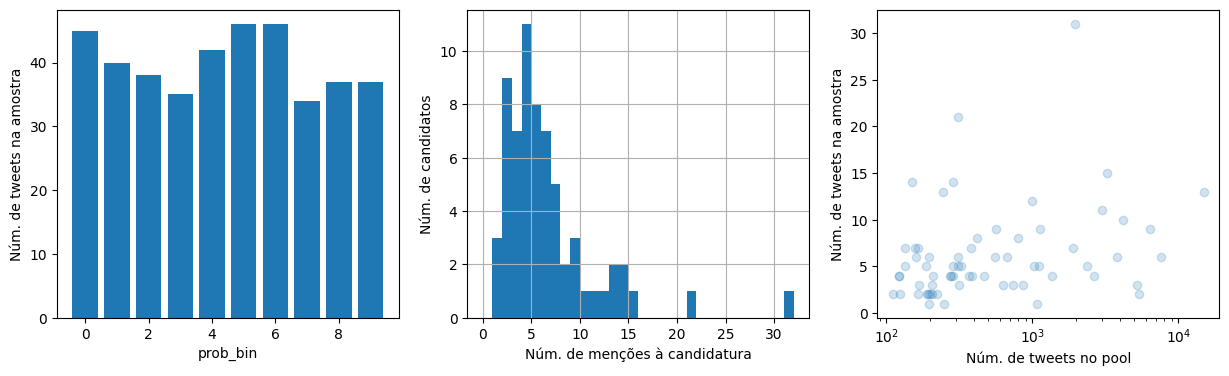

In [9]:
# Build sample:
q = perfis_df['DS_COR_RACA'].isin(['PRETA', 'PARDA'])
tweet_sample_df = af.sample_tweets_in_group(campaign_df, perfis_df, q, min_mentions, prob_bin, 1.1, n_samples, 10874)

# Show statistics:
print(xd.bold('Diagnóstico da amostra'))
af.plot_tweet_sampling_diagnosis(tweet_sample_df)

# Export:
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#af.export_sample_for_annotation(tweet_sample_df, '../dados/processados/amostra_tweets_para_anotacao_{}.csv', 'racista')

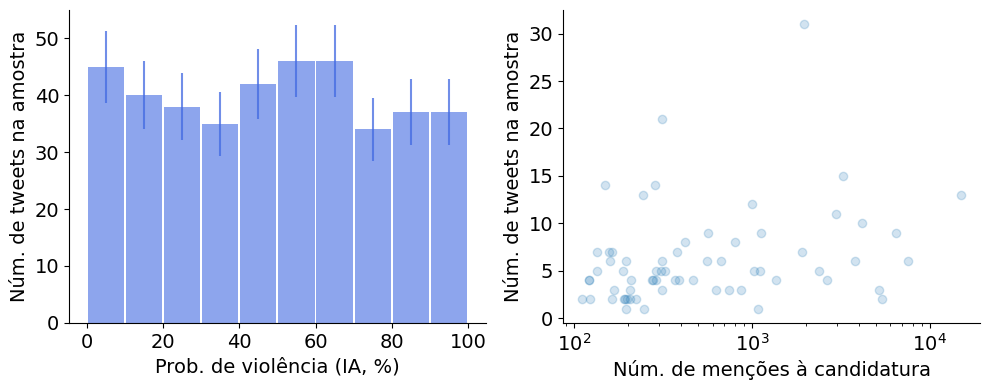

In [10]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
xp.errorbar_hist(tweet_sample_df['hate_score'] * 100, np.arange(0, 101, 10), rwidth=0.95, color='royalblue')
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=14)
pl.xlabel('Prob. de violência (IA, %)', fontsize=14)
pl.ylabel('Núm. de tweets na amostra', fontsize=14)

test_sampling = pd.DataFrame()
test_sampling['counts']   = tweet_sample_df['batch_user'].value_counts()
test_sampling['mentions'] = tweet_sample_df[['batch_user', 'n_batch_user']].drop_duplicates().set_index('batch_user')

pl.subplot(1,2,2)
pl.scatter(test_sampling['mentions'], test_sampling['counts'], alpha=0.2)
pl.xscale('log')
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=14)
pl.xlabel('Núm. de menções à candidatura', fontsize=14)
pl.ylabel('Núm. de tweets na amostra', fontsize=14)

pl.tight_layout()
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#pl.savefig(Path('../resultados/plots/plot_uniformidade_amostra_tweets_negros.svg'))
#pl.savefig(Path('../resultados/plots/plot_uniformidade_amostra_tweets_negros.png'))
pl.show()

### Mulheres

Encontramos 972 perfis nesse grupo.
Encontramos 95 perfis com no mínimo 100 menções.
Diagnóstico da amostra


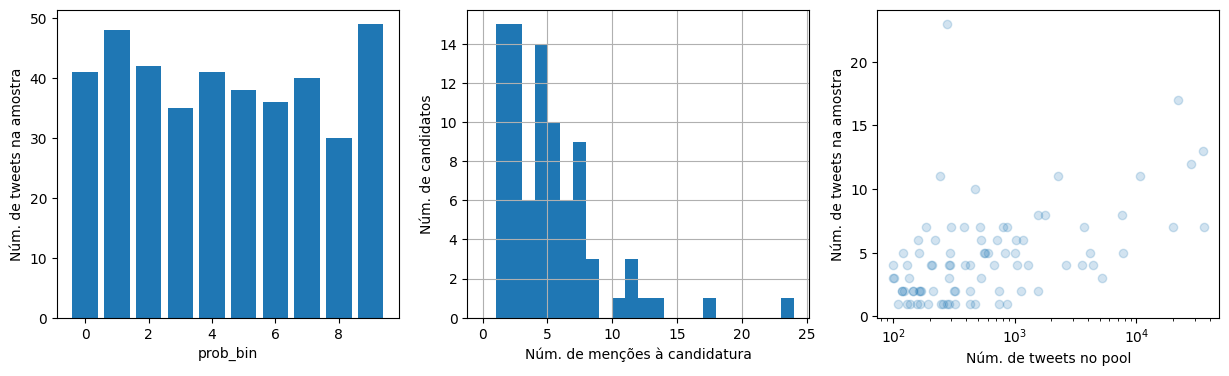

In [11]:
# Build sample:
q = perfis_df['DS_GENERO'].isin(['FEMININO'])
tweet_sample_df = af.sample_tweets_in_group(campaign_df, perfis_df, q, min_mentions, prob_bin, 1.15, n_samples, 10261)

# Show statistics:
print(xd.bold('Diagnóstico da amostra'))
af.plot_tweet_sampling_diagnosis(tweet_sample_df)

# Export:
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#af.export_sample_for_annotation(tweet_sample_df, '../dados/processados/amostra_tweets_para_anotacao_{}.csv', 'machista')

### LGBT

Encontramos 118 perfis nesse grupo.
Encontramos 21 perfis com no mínimo 100 menções.
Diagnóstico da amostra


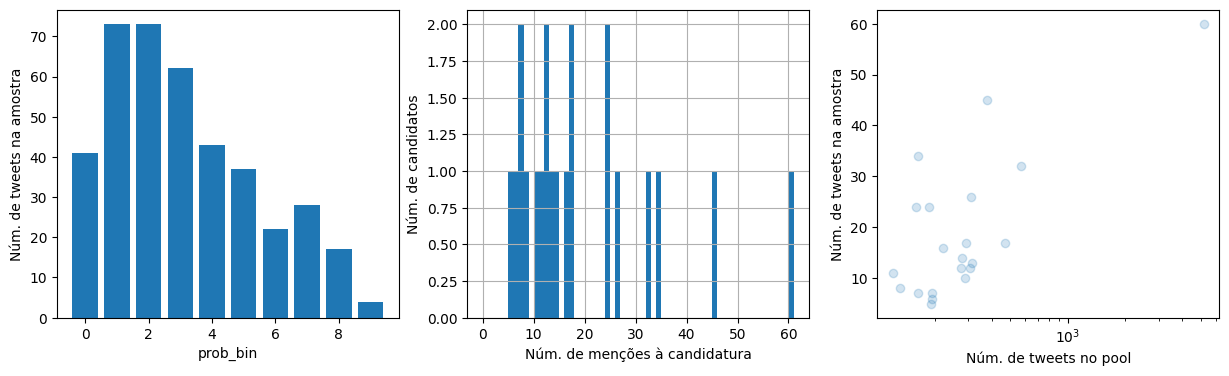

In [12]:
# Build sample:
q = perfis_df['VOTE_LGBT'].isin(['CADASTRADA'])
tweet_sample_df = af.sample_tweets_in_group(campaign_df, perfis_df, q, min_mentions, prob_bin, 1.3, n_samples, 2317910)

# Show statistics:
print(xd.bold('Diagnóstico da amostra'))
af.plot_tweet_sampling_diagnosis(tweet_sample_df)

# Export:
#af.export_sample_for_annotation(tweet_sample_df, '../dados/processados/amostra_tweets_para_anotacao_{}.csv', 'LGBTfóbico')

### Controle

Encontramos 1660 perfis nesse grupo.
Encontramos 144 perfis com no mínimo 100 menções.
Diagnóstico da amostra


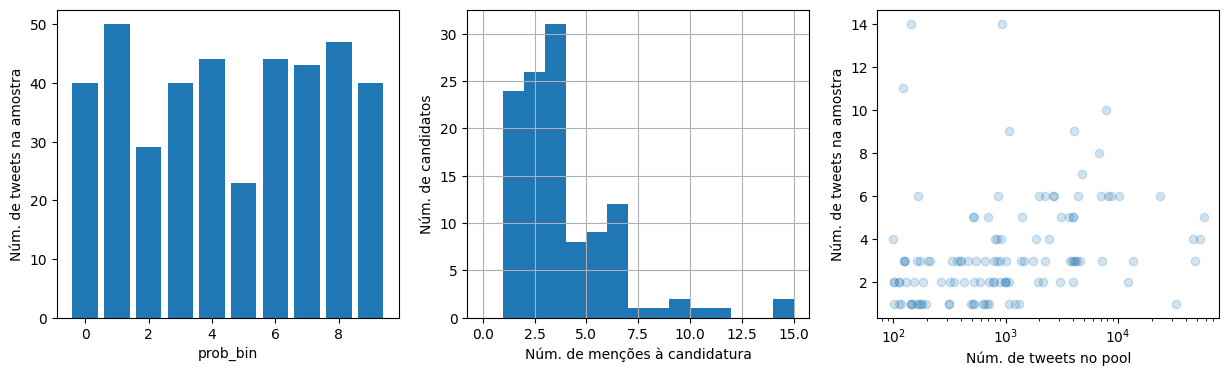

In [13]:
# Build sample:
q = perfis_df['DS_GENERO'].isin(['MASCULINO']) & perfis_df['DS_COR_RACA'].isin(['BRANCA']) & perfis_df['VOTE_LGBT'].isin(['NÃO CADASTRADA'])  
tweet_sample_df = af.sample_tweets_in_group(campaign_df, perfis_df, q, min_mentions, prob_bin, 1.1, n_samples, 108626)

# Show statistics:
print(xd.bold('Diagnóstico da amostra'))
af.plot_tweet_sampling_diagnosis(tweet_sample_df)

# Export:
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#af.export_sample_for_annotation(tweet_sample_df, '../dados/processados/amostra_tweets_para_anotacao_{}.csv', 'controle')#

## Análises auxiliares

### Violência é concentrada nas candidaturas mais populares?

In [14]:
# Menções por candidato:
n_mentions_per_cand = campaign_df['batch_user'].value_counts()

In [15]:
# Dados sobre a distribuição:
#n_mentions_per_cand.loc[n_mentions_per_cand < 10].sum()
#len(n_mentions_per_cand.loc[n_mentions_per_cand < 10])
#len(n_mentions_per_cand.loc[n_mentions_per_cand > 1e4])

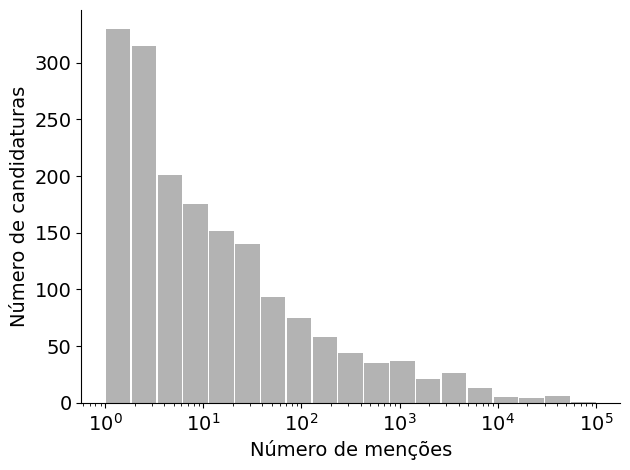

In [16]:
# Distribuição das candidaturas por menção:
edges = np.logspace(0.0, 5.0, 20)

pl.hist(n_mentions_per_cand, bins=edges, rwidth=0.95, color='0.7')
pl.xscale('log')
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=14)
pl.xlabel('Número de menções', fontsize=14)
pl.ylabel('Número de candidaturas', fontsize=14)
pl.tight_layout()
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#pl.savefig(Path('../resultados/plots/hist_candidaturas_por_n_mencoes.eps'))
#pl.savefig(Path('../resultados/plots/hist_candidaturas_por_n_mencoes.png'))
pl.show()

# tweets a populares: 781406
# tweets a desconhecidos: 18581


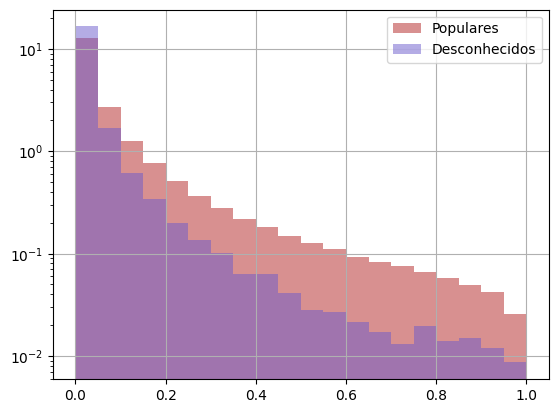

In [17]:
# Concentração de violência:

popular_cands = n_mentions_per_cand.loc[n_mentions_per_cand > 100].index
unknown_cands = n_mentions_per_cand.loc[n_mentions_per_cand < 100].index
tweets_to_popular_df = campaign_df.loc[campaign_df['batch_user'].isin(popular_cands)]
tweets_to_unknown_df = campaign_df.loc[campaign_df['batch_user'].isin(unknown_cands)]
print('# tweets a populares:', len(tweets_to_popular_df))
print('# tweets a desconhecidos:', len(tweets_to_unknown_df))


edges = np.arange(0, 1.01, 0.05)
tweets_to_popular_df['hate_score'].hist(bins=edges, density=True, alpha=0.5, color='firebrick', label='Populares')
tweets_to_unknown_df['hate_score'].hist(bins=edges, density=True, alpha=0.5, color='slateblue', label='Desconhecidos')
pl.legend()
pl.yscale('log')
pl.show()

### Tweets violentos são incomuns?

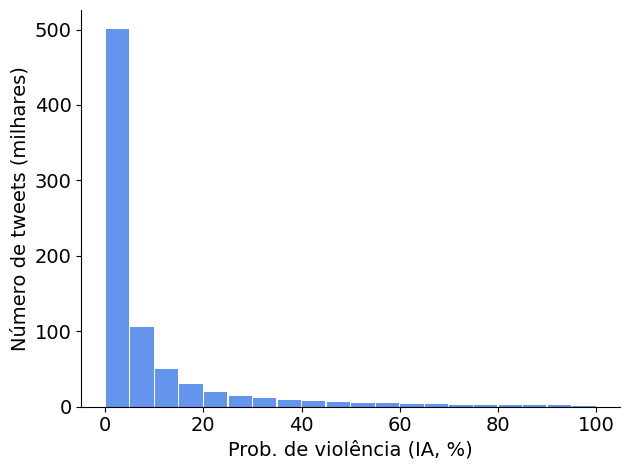

In [18]:
edges = np.arange(0, 101, 5)
pl.hist(tweets_to_popular_df['hate_score'] * 100, bins=edges, color='cornflowerblue', alpha=1.0, rwidth=0.95)
tick_pos    = np.linspace(0, 5e5, 6)
tick_labels = tick_pos / 1000
pl.yticks(tick_pos, tick_labels.astype(int))
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=14)
pl.xlabel('Prob. de violência (IA, %)', fontsize=14)
pl.ylabel('Número de tweets (milhares)', fontsize=14)
#pl.yscale('log')
pl.tight_layout()
# Para salvar o resultado, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#pl.savefig(Path('../resultados/plots/hist_tweets_por_hate-score.eps'))
#pl.savefig(Path('../resultados/plots/hist_tweets_por_hate-score.png'))
pl.show()

#### Exportando a densidade de tweets por score de violência

In [19]:
from scipy.signal import savgol_filter

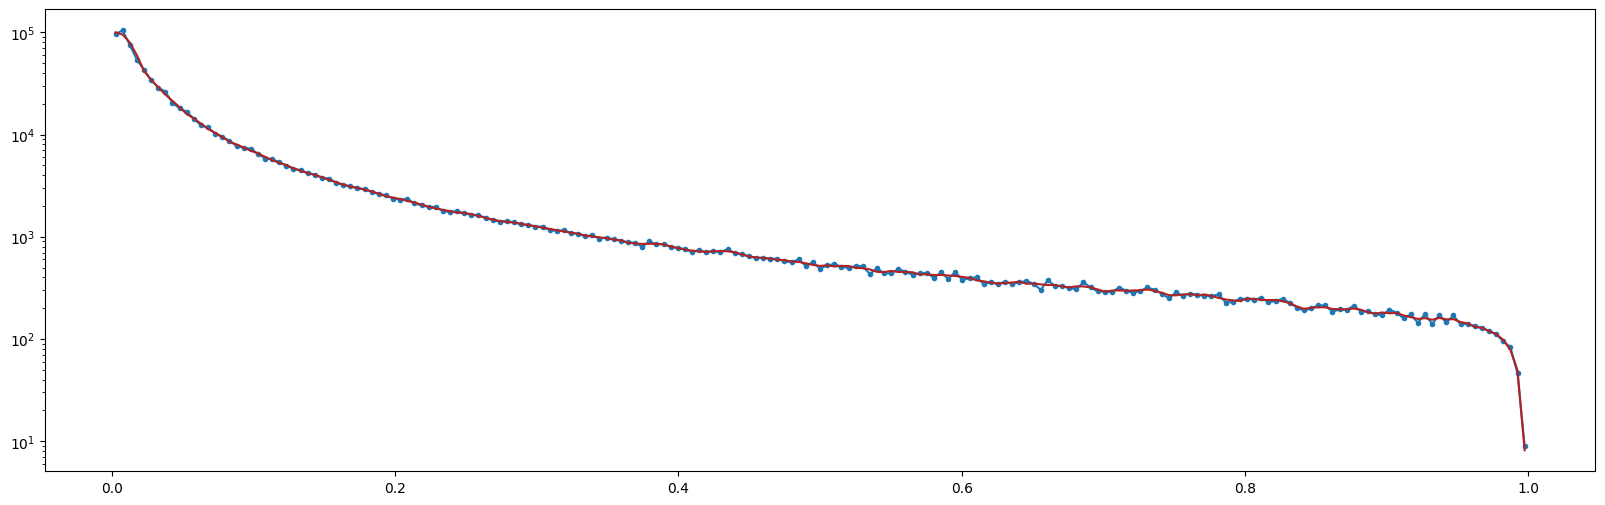

In [20]:
edges = np.linspace(0, 1, 200)
counts, edges = np.histogram(tweets_to_popular_df['hate_score'], bins=edges)
smooth = savgol_filter(counts, 7, 3)
center = (edges[1:] + edges[:-1]) / 2

pl.figure(figsize=(20,6))
pl.plot(center, counts, marker='.')
pl.plot(center, smooth, color='firebrick')
pl.yscale('log')
pl.show()

In [21]:
# Prepara tabela para exportação:
mass = counts.sum()
dx = np.mean(edges[1:] - edges[:-1])
density = smooth / mass / dx
density_df = pd.DataFrame({'hate_score': edges[:-1], 'tweet_density': density})
# Para salvar os dados processados, descomente a linha abaixo (ela fica comentada para evitar sobrescrever o arquivo por acidente):
#density_df.to_csv(Path('../dados/processados/dens_eletweets100+_por_score.csv'), index=False)